In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from transformers import pipeline

from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

In [2]:
# load toxicity annotation model
toxpipe = pipeline("text-classification", model="cooperleong00/deberta-v3-large_toxicity-scorer")

In [3]:
# read in original data
dfa = pd.read_csv('../data/toxicity_annotations.tsv',sep='\t')
dfc = pd.read_csv('../data/toxicity_annotated_comments.tsv',sep='\t')

# read in dialect subsets
aave = pd.read_json("../data/aave.jsonl", lines=True)
nigerianD = pd.read_json("../data/nigerianD.jsonl", lines=True)
indianD = pd.read_json("../data/indianD.jsonl", lines=True)
singlish = pd.read_json("../data/singlish.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
dfa_sample = dfa.iloc[:1000]

In [ ]:
dfa_sample.head()

In [ ]:
dfc.head()

In [ ]:
aave.head()

### run DeBERTa toxicity scorer on the original texts and all 4 dialects

In [9]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float) 
    
    return lconf

In [6]:
lconf_og_1k = get_label_confidence(dfc["comment"][:1000])
lconf_og_1k.to_csv("../data/lconf_og_1k.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/lconf_aave_1k.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/lconf_nigerianD_1k.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/lconf_indianD_1k.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/lconf_singlish_1k.csv", sep=",", index=False)

100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s] 


### check DeBERTa toxicity ratings of the first 1000  sentences

In [14]:
# load saved predictions and check distribution of labels   
lconf_og_1k = pd.read_csv("../data/lconf_og_1k.csv")
lconf_aave_1k = pd.read_csv("../data/lconf_aave_1k.csv")
lconf_nigerianD_1k = pd.read_csv("../data/lconf_nigerianD_1k.csv")
lconf_indianD_1k = pd.read_csv("../data/lconf_indianD_1k.csv")
lconf_singlish_1k = pd.read_csv("../data/lconf_singlish_1k.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({0.0: 964, 1.0: 36})
Counter({0.0: 963, 1.0: 37})
Counter({0.0: 965, 1.0: 35})
Counter({0.0: 966, 1.0: 34})
Counter({0.0: 963, 1.0: 37})


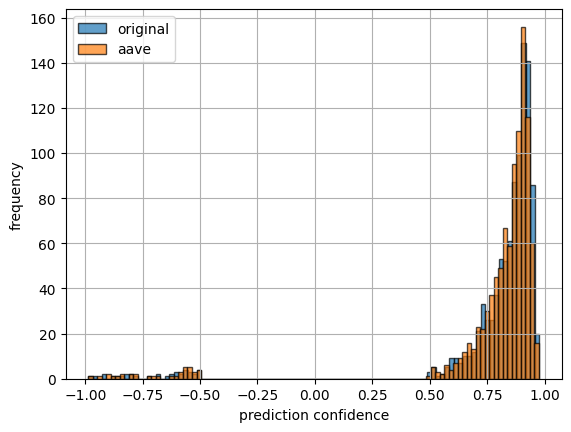

In [15]:
plt.hist(lconf_og_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="original")
plt.hist(lconf_aave_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="aave")
plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

### KS test trial runs

In [16]:
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=0.07200, p=0.01119
Statistics=0.05600, p=0.08690
Statistics=0.05400, p=0.10829
Statistics=0.10100, p=0.00007


In [20]:
print("non-toxic only: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_aave_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_nigerianD_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_indianD_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_singlish_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))

non-toxic only: KS test for prediction confidence original vs. dialects
Statistics=0.07245, p=0.01149
Statistics=0.05637, p=0.08949
Statistics=0.05429, p=0.11049
Statistics=0.10447, p=0.00005


In [21]:
print("toxic only: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_aave_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_nigerianD_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_indianD_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_singlish_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))

toxic only: KS test for prediction confidence original vs. dialects
Statistics=0.12838, p=0.86492
Statistics=0.08254, p=0.99743
Statistics=0.14216, p=0.80039
Statistics=0.09459, p=0.98719


### Mann Whitney U test trial runs

In [23]:
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=532990.50000, p=0.01063
Statistics=527190.50000, p=0.03524
Statistics=522656.50000, p=0.07935
Statistics=549670.50000, p=0.00012


In [25]:
print("toxic only: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_aave_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_nigerianD_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_indianD_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c > 0], [abs(c) for c in lconf_singlish_1k["confidence"] if c > 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))

toxic only: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=495677.00000, p=0.00988
Statistics=491538.00000, p=0.03086
Statistics=487759.00000, p=0.07043
Statistics=512274.00000, p=0.00008


In [26]:
print("non-toxic only: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_aave_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_nigerianD_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_indianD_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"] if c < 0], [abs(c) for c in lconf_singlish_1k["confidence"] if c < 0])
print('Statistics=%.5f, p=%.5f' % (stat, p))

non-toxic only: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=712.50000, p=0.61176
Statistics=632.50000, p=0.98165
Statistics=682.50000, p=0.41074
Statistics=700.50000, p=0.70754


### some other statistics

In [29]:
print(np.average([c for c in lconf_og_1k["confidence"]]))
print(np.average([c for c in lconf_aave_1k["confidence"]]))
print(np.average([c for c in lconf_nigerianD_1k["confidence"]]))
print(np.average([c for c in lconf_indianD_1k["confidence"]]))

0.7971735123991966
0.7897873933911324
0.7925030663609505
0.796678382396698


In [8]:
# average confidence of toxic predictions  
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c < 0]))
print("")

# average confidence of non-toxic predictions  
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c > 0]))

0.6760093635982938
0.6629518753773457
0.6716517278126308
0.6530748658320483

0.8521886405484805
0.8456039592732026
0.8456071262532565
0.8477048942391177


## Try out Twitter data

In [4]:
# read in original data
dft = pd.read_csv('../data/labeled_data.csv', sep=',', index_col=0)

# read in dialect subsets
aave = pd.read_json("../data/aave_tw.jsonl", lines=True)
nigerianD = pd.read_json("../data/nigerianD_tw.jsonl", lines=True)
indianD = pd.read_json("../data/indianD_tw.jsonl", lines=True)
singlish = pd.read_json("../data/singlish_tw.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
dft_sample = dft.iloc[:1000]

In [5]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float) 
    
    return lconf

In [6]:
dft_sample.head(10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [10]:
lconf_og_1k = get_label_confidence(dft_sample["tweet"][:1000])
lconf_og_1k.to_csv("../data/lconf_og_1k_tw.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/lconf_aave_1k_tw.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/lconf_nigerianD_1k_tw.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/lconf_indianD_1k_tw.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/lconf_singlish_1k_tw.csv", sep=",", index=False)

In [19]:
# load saved predictions and check distribution of labels   
lconf_og_1k = pd.read_csv("../data/lconf_og_1k_tw.csv")
lconf_aave_1k = pd.read_csv("../data/lconf_aave_1k_tw.csv")
lconf_nigerianD_1k = pd.read_csv("../data/lconf_nigerianD_1k_tw.csv")
lconf_indianD_1k = pd.read_csv("../data/lconf_indianD_1k_tw.csv")
lconf_singlish_1k = pd.read_csv("../data/lconf_singlish_1k_tw.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({1.0: 796, 0.0: 204})
Counter({1.0: 778, 0.0: 222})
Counter({1.0: 790, 0.0: 210})
Counter({1.0: 779, 0.0: 221})
Counter({1.0: 779, 0.0: 221})


In [20]:
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=0.05100, p=0.14836
Statistics=0.04000, p=0.40063
Statistics=0.06600, p=0.02563
Statistics=0.06100, p=0.04840


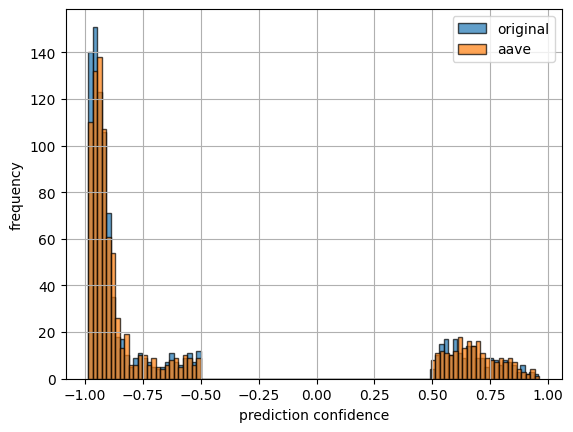

In [21]:
plt.hist(lconf_og_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="original")
plt.hist(lconf_aave_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="aave")
plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()